# Consumption prediction using SVR

In this notebook we will try to demonstrate the usage of SVR for consumption prediction for following day.First of all, let's load some consumption data.

In [1]:
from datetime import datetime
from datetime import timedelta

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

First of all, let's load some consumption data.

In [2]:
df = pd.read_csv('.exports/user_data_joined/user26.csv')
df.head()

,year,month,day,hour,weekday,spotreba,pv,grid
0,2014,1,1,0,2,1.817583,0.0,1.817583
1,2014,1,1,1,2,1.040650,0.0,1.040650
2,2014,1,1,2,2,0.367133,0.0,0.367067
3,2014,1,1,3,2,0.297983,0.0,0.297933
4,2014,1,1,4,2,0.294083,0.0,0.294083


Vyberieme obdobie jedného mesiaca a vykreslime si graf spotreby, nech tušíme.

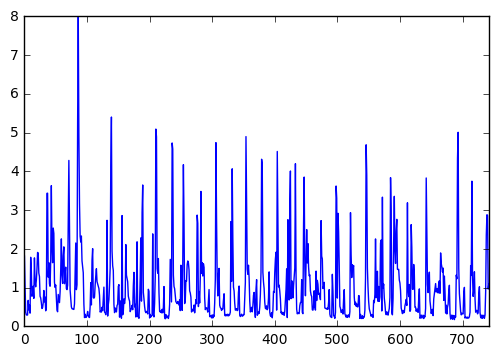

In [3]:
from utils import data as dutils

df_month = dutils.select_range(df, datetime(2014,1,1), datetime(2014,1,31))

df_month['spotreba'].plot()

In [4]:
from sklearn import svm

Naše featury zatiaľ budú hodina a weekday a zoberieme dva týždne. Závislá premenná je samozrejme spotreba.

In [5]:
training_subset = dutils.select_range(df, datetime(2014, 1, 1), datetime(2014, 1, 14))

X = training_subset[['hour', 'weekday']].as_matrix()
y = training_subset['spotreba'].as_matrix()

Train the SVR regressor.

In [6]:
clf = svm.SVR()
clf.fit(X, y)

SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

A vyberieme testovacie dáta, na ktorých overíme (nasledujúci deň):

In [7]:
testing_subset = dutils.select_range(df, datetime(2014, 1, 15), datetime(2014, 1, 15))

X_test = testing_subset[['hour', 'weekday']].as_matrix()
y_test = testing_subset['spotreba'].as_matrix()

y_pred = clf.predict(X_test)

Vykreslíme graf a vypočítame MAPE chybu:

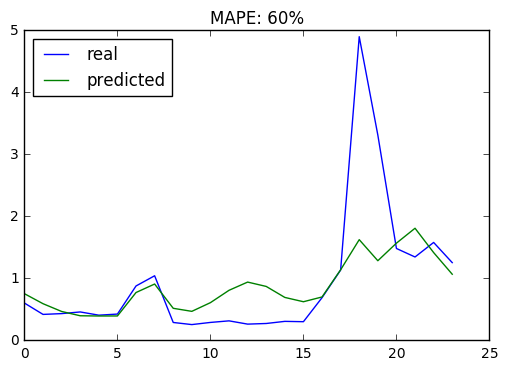

In [8]:
def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


fig, ax = plt.subplots(1,1)
ax.plot(y_test, label='real')
ax.plot(y_pred, label='predicted')
error = mape(y_test, y_pred)
ax.legend(loc=0)
ax.set_title('MAPE: %d%%'%error)

In [10]:
import prediction.predictor as prd

In [13]:
# this is the first evaluation day
eval_day = datetime(2015,1,1)
# features used for traning
features = ['hour', 'weekday']
evals = 365

In [14]:
for i in range(1,9):
    days_to_train = 7*i
    error = prd.train_and_eval(df, eval_day, features, days_to_train, evals)
    print('Weeks to train %d, MAPE: %f'%(i, error))


Weeks to train 1, MAPE: 53.682031
Weeks to train 2, MAPE: 49.900888
Weeks to train 3, MAPE: 50.142049
Weeks to train 4, MAPE: 50.359747
Weeks to train 5, MAPE: 51.514931
Weeks to train 6, MAPE: 52.855436
Weeks to train 7, MAPE: 53.998322
Weeks to train 8, MAPE: 55.471086
